In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from tqdm import tqdm

# Two Possible Factors Found

In [ ]:
# Zihang Zhao

In [2]:
start_date = '2022-01-01'
end_date = '2023-01-01'

In [3]:
spy = yf.Ticker("SPY")
sp500_tickers = spy.history(period="1d")['Close'].index.tolist()

In [5]:
components_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
components_table = pd.read_html(components_url)
components_df = components_table[0]
sp500_tickers = components_df['Symbol'].tolist()

In [6]:
factor_data_list = []

In [7]:
for ticker in tqdm(sp500_tickers):
    try:
        # Get historical data
        data = yf.download(ticker, start=start_date, end=end_date)
        
        # Calculate daily returns
        data['daily_return'] = data['Adj Close'].pct_change()
        
        # Factor Calculation
        data['monthly_intraday_momentum'] = data['daily_return'].rolling(window=20, min_periods=20).sum()
        top_20_amplitude = data['High'].rolling(window=20, min_periods=20).quantile(0.8)
        bottom_20_amplitude = data['Low'].rolling(window=20, min_periods=20).quantile(0.2)
        data['amplified_adjusted_momentum'] = top_20_amplitude - bottom_20_amplitude
        data['monthly_high_low_amplitude'] = (data['High'] - data['Low']).rolling(window=20, min_periods=20).mean()
        data['normalized_upshadow'] = (data['High'] - data[['Open', 'Close']].max(axis=1)) / data['High']
        data['average_monthly_normalized_upshadow'] = data['normalized_upshadow'].rolling(window=20, min_periods=20).mean()
        data['average_turnover'] = data['Volume'].rolling(window=20, min_periods=20).mean()
        data['price_turnover_corr'] = data['Adj Close'].rolling(window=20, min_periods=20).corr(data['Volume'])
        data['turnover_nextday_return_corr'] = data['Volume'].rolling(window=20, min_periods=20).corr(data['daily_return'].shift(-1))
        data['turnover_return_corr'] = data['Volume'].rolling(window=20, min_periods=20).corr(data['daily_return'])
        
        # Add ticker column
        data['ticker'] = ticker
        
        # Append to the list
        factor_data_list.append(data[['ticker', 'monthly_intraday_momentum', 'amplified_adjusted_momentum', 
                                      'monthly_high_low_amplitude', 'average_monthly_normalized_upshadow',
                                      'average_turnover', 'price_turnover_corr',
                                      'turnover_nextday_return_corr', 'turnover_return_corr', 'daily_return']])
    except Exception as e:
        print(f"Failed to process {ticker}: {e}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$BF.B: possibly delisted; No price data found  (1d 2022-01-01 -> 2023-01-01)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [8]:
factor_data = pd.concat(factor_data_list)

In [9]:
# Remove rows with NA values for 'monthly_intraday_momentum' and 'turnover_return_corr'
factor_data = factor_data.dropna(subset=['monthly_intraday_momentum', 'turnover_return_corr'])

In [10]:
factor_data = factor_data.fillna(method='ffill')


In [11]:
na_counts = factor_data.isna().sum()
print(na_counts)

ticker                                 0
monthly_intraday_momentum              0
amplified_adjusted_momentum            0
monthly_high_low_amplitude             0
average_monthly_normalized_upshadow    0
average_turnover                       0
price_turnover_corr                    0
turnover_nextday_return_corr           0
turnover_return_corr                   0
daily_return                           0
dtype: int64


In [12]:
factor_data

,ticker,monthly_intraday_momentum,amplified_adjusted_momentum,monthly_high_low_amplitude,average_monthly_normalized_upshadow,average_turnover,price_turnover_corr,turnover_nextday_return_corr,turnover_return_corr,daily_return
Date,,,,,,,,,,
2022-02-01,MMM,-0.057450,10.690634,3.381271,0.004518,3791487.45,-0.789201,0.243351,-0.311299,0.008493
2022-02-02,MMM,-0.076058,11.115378,3.390468,0.004663,3831499.65,-0.744584,0.242236,-0.291480,-0.004599
2022-02-03,MMM,-0.085572,12.518393,3.300586,0.004174,3810946.40,-0.655109,0.258995,-0.270837,-0.013621
2022-02-04,MMM,-0.099535,12.941476,3.338212,0.004352,3903104.20,-0.639965,0.315272,-0.308167,-0.022264
2022-02-07,MMM,-0.107753,13.602008,3.297660,0.004553,3881630.05,-0.531772,0.270325,-0.310327,0.002738
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,ZTS,-0.026454,13.010007,3.630502,0.005611,2344350.00,0.178212,-0.076939,0.081238,0.005033
2022-12-27,ZTS,-0.016485,13.010007,3.651502,0.005520,2310580.00,0.222920,-0.039140,0.063187,-0.003156
2022-12-28,ZTS,-0.024712,13.010007,3.649001,0.005516,2294420.00,0.253983,-0.053501,0.083269,-0.010117


In [13]:
# Normalize the factors after handling NAs
factors = ['monthly_intraday_momentum', 'amplified_adjusted_momentum', 'monthly_high_low_amplitude',
           'average_monthly_normalized_upshadow', 'average_turnover', 'price_turnover_corr',
           'turnover_nextday_return_corr', 'turnover_return_corr']

In [14]:
for factor in factors:
    factor_data[factor] = (factor_data[factor] - factor_data[factor].mean()) / factor_data[factor].std()

In [15]:
# Factor Validation
# Calculate IC values
def calculate_ic(factor, returns):
    return factor.rolling(window=20).corr(returns)

In [16]:
factor_data

,ticker,monthly_intraday_momentum,amplified_adjusted_momentum,monthly_high_low_amplitude,average_monthly_normalized_upshadow,average_turnover,price_turnover_corr,turnover_nextday_return_corr,turnover_return_corr,daily_return
Date,,,,,,,,,,
2022-02-01,MMM,-0.557831,-0.170933,-0.163486,-0.969026,-0.098214,-1.964077,0.869797,-0.962100,0.008493
2022-02-02,MMM,-0.744222,-0.155034,-0.162392,-0.912325,-0.096719,-1.832539,0.864823,-0.900407,-0.004599
2022-02-03,MMM,-0.839528,-0.102519,-0.173090,-1.104531,-0.097487,-1.568757,0.939583,-0.836152,-0.013621
2022-02-04,MMM,-0.979394,-0.086683,-0.168611,-1.034554,-0.094044,-1.524111,1.190626,-0.952350,-0.022264
2022-02-07,MMM,-1.061704,-0.061959,-0.173438,-0.955306,-0.094846,-1.205145,0.990128,-0.959073,0.002738
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,ZTS,-0.247355,-0.084118,-0.133821,-0.539404,-0.152279,0.887977,-0.558972,0.259774,0.005033
2022-12-27,ZTS,-0.147497,-0.084118,-0.131322,-0.575275,-0.153541,1.019783,-0.390354,0.203585,-0.003156
2022-12-28,ZTS,-0.229904,-0.084118,-0.131619,-0.576987,-0.154144,1.111360,-0.454415,0.266094,-0.010117


In [17]:
ic_values = {}
for factor in factors:
    ic_values[factor] = calculate_ic(factor_data[factor], factor_data['daily_return'])

# Aggregate IC values across the entire market
aggregate_ic = {factor: ic_values[factor].mean() for factor in factors}

In [18]:
aggregate_ic

{'monthly_intraday_momentum': 0.24722873315772068,
 'amplified_adjusted_momentum': 0.035074328887252995,
 'monthly_high_low_amplitude': 0.020100565119568682,
 'average_monthly_normalized_upshadow': 0.03785865829788664,
 'average_turnover': 0.04590196805603258,
 'price_turnover_corr': 0.03925177069560223,
 'turnover_nextday_return_corr': 0.013263438234162461,
 'turnover_return_corr': 0.06085155263664106}

In [19]:
factor_returns = {}
for factor in factors:
    factor_returns[factor] = factor_data[factor] * factor_data['daily_return']

aggregate_returns = {factor: factor_returns[factor].groupby(factor_data.index).mean().cumsum() for factor in factors}

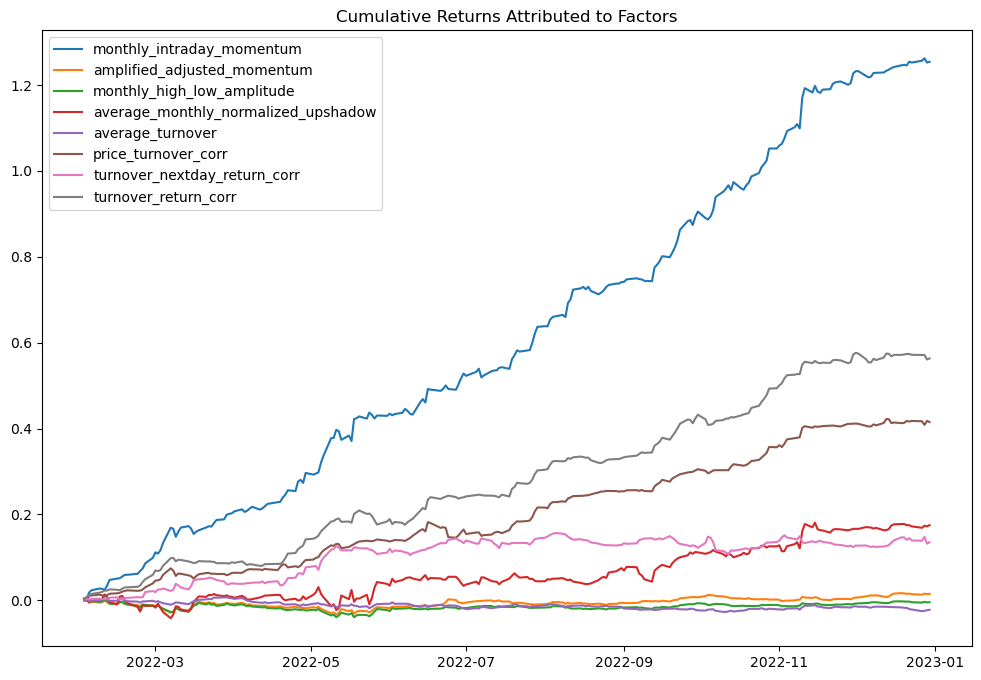

In [20]:
plt.figure(figsize=(12, 8))
for factor, ret in aggregate_returns.items():
    plt.plot(ret.index, ret.values, label=factor)
plt.legend()
plt.title('Cumulative Returns Attributed to Factors')
plt.show()

# Rebalance, performance not so good, perhaps because the of the rebalance logic

In [21]:
factor_data['combined_score'] = factor_data['monthly_intraday_momentum'] + factor_data['turnover_return_corr']


In [35]:
# Select the top 15 stocks based on the combined score
top_stocks = factor_data.groupby('ticker')['combined_score'].mean().nlargest(7).index

In [36]:
top_stocks

Index(['SMCI', 'ENPH', 'FSLR', 'OXY', 'MRNA', 'CEG', 'PTC'], dtype='object', name='ticker')

In [37]:
backtest_data = pd.DataFrame()

In [38]:
# Select the data for the top 15 stocks
for ticker in top_stocks:
    data = factor_data[factor_data['ticker'] == ticker]
    data = data[['ticker', 'daily_return']]
    backtest_data = pd.concat([backtest_data, data])

In [39]:
backtest_data_pivot = backtest_data.pivot(columns='ticker', values='daily_return')

In [40]:
backtest_data_pivot = backtest_data_pivot.fillna(0)

In [41]:
portfolio_returns = backtest_data_pivot.mean(axis=1)

In [42]:
portfolio_returns

Date
2022-02-01    0.014044
2022-02-02    0.000538
2022-02-03   -0.037750
2022-02-04    0.009064
2022-02-07   -0.006140
                ...   
2022-12-23   -0.003419
2022-12-27   -0.028280
2022-12-28   -0.023182
2022-12-29    0.009201
2022-12-30    0.001056
Length: 231, dtype: float64

In [43]:
cumulative_returns = (1 + portfolio_returns).cumprod() - 1

In [44]:
cumulative_returns

Date
2022-02-01    0.014044
2022-02-02    0.014589
2022-02-03   -0.023712
2022-02-04   -0.014863
2022-02-07   -0.020912
                ...   
2022-12-23    0.802786
2022-12-27    0.751804
2022-12-28    0.711194
2022-12-29    0.726939
2022-12-30    0.728762
Length: 231, dtype: float64

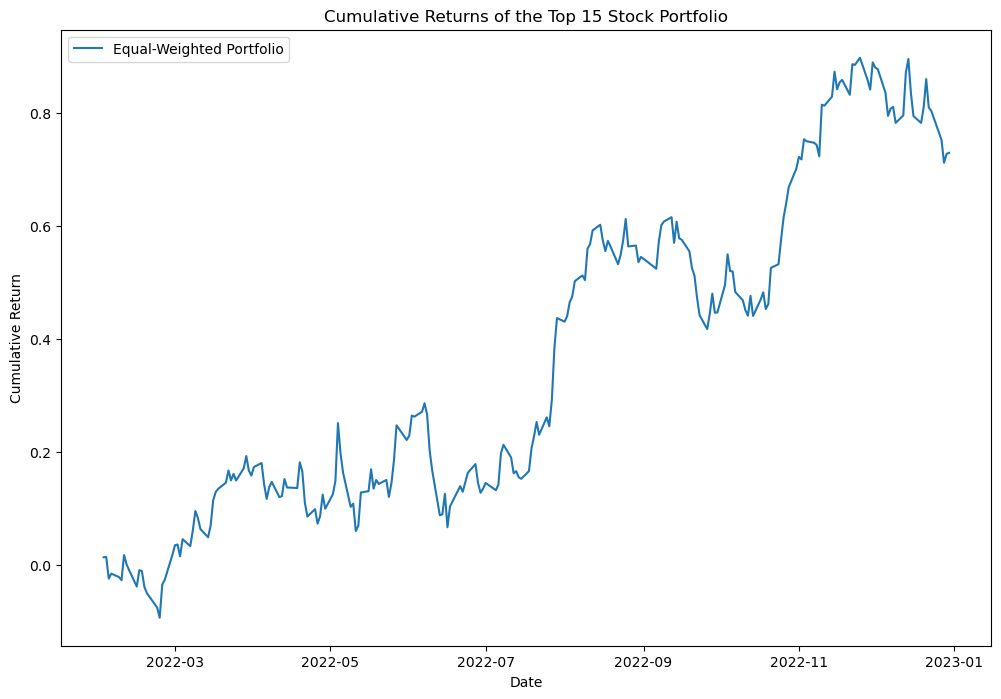

In [45]:
# Plot the cumulative returns
plt.figure(figsize=(12, 8))
plt.plot(cumulative_returns.index, cumulative_returns, label='Equal-Weighted Portfolio')
plt.legend()
plt.title('Cumulative Returns of the Top 15 Stock Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

In [33]:
all_data = {}

In [34]:
for ticker in tqdm(sp500_tickers):
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        data['daily_return'] = data['Adj Close'].pct_change()
        all_data[ticker] = data
    except Exception as e:
        print(f"Failed to process {ticker}: {e}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$BF.B: possibly delisted; No price data found  (1d 2022-01-01 -> 2023-01-01)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [46]:
factor_data_V = pd.DataFrame()

In [47]:
for ticker, data in all_data.items():
    try:
        data['monthly_intraday_momentum'] = data['daily_return'].rolling(window=20).sum()
        data['turnover_return_corr'] = data['Volume'].rolling(window=20).corr(data['daily_return'])
        data['ticker'] = ticker
        factor_data_V = pd.concat([factor_data_V, data[['ticker', 'monthly_intraday_momentum', 'turnover_return_corr', 'daily_return']]])
    except Exception as e:
        print(f"Failed to calculate factors for {ticker}: {e}")

In [48]:
factor_data_V

,ticker,monthly_intraday_momentum,turnover_return_corr,daily_return
Date,,,,
2022-01-03,MMM,NaN,NaN,NaN
2022-01-04,MMM,NaN,NaN,0.014009
2022-01-05,MMM,NaN,NaN,-0.004106
2022-01-06,MMM,NaN,NaN,-0.008301
2022-01-07,MMM,NaN,NaN,0.010955
...,...,...,...,...
2022-12-23,ZTS,-0.026454,0.081237,0.005033
2022-12-27,ZTS,-0.016485,0.063187,-0.003156
2022-12-28,ZTS,-0.024712,0.083269,-0.010117


In [49]:
factor_data_V = factor_data_V.dropna(subset=['monthly_intraday_momentum', 'turnover_return_corr'])

In [50]:
factor_data_V['monthly_intraday_momentum'] = (factor_data_V['monthly_intraday_momentum'] - factor_data_V['monthly_intraday_momentum'].mean()) / factor_data_V['monthly_intraday_momentum'].std()
factor_data_V['turnover_return_corr'] = (factor_data_V['turnover_return_corr'] - factor_data_V['turnover_return_corr'].mean()) / factor_data_V['turnover_return_corr'].std()

C:\Users\zhaoz\AppData\Local\Temp\ipykernel_13320\2739899949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factor_data_V['monthly_intraday_momentum'] = (factor_data_V['monthly_intraday_momentum'] - factor_data_V['monthly_intraday_momentum'].mean()) / factor_data_V['monthly_intraday_momentum'].std()
C:\Users\zhaoz\AppData\Local\Temp\ipykernel_13320\2739899949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factor_data_V['turnover_return_corr'] = (factor_data_V['turnover_return_corr'] - factor_data_

In [51]:
factor_data_V

,ticker,monthly_intraday_momentum,turnover_return_corr,daily_return
Date,,,,
2022-02-01,MMM,-0.557830,-0.962103,0.008493
2022-02-02,MMM,-0.744222,-0.900410,-0.004599
2022-02-03,MMM,-0.839528,-0.836155,-0.013621
2022-02-04,MMM,-0.979390,-0.952356,-0.022264
2022-02-07,MMM,-1.061706,-0.959078,0.002737
...,...,...,...,...
2022-12-23,ZTS,-0.247352,0.259771,0.005033
2022-12-27,ZTS,-0.147499,0.203586,-0.003156
2022-12-28,ZTS,-0.229905,0.266095,-0.010117


In [52]:
factor_data_V['combined_score'] = factor_data_V['monthly_intraday_momentum'] + factor_data_V['turnover_return_corr']

C:\Users\zhaoz\AppData\Local\Temp\ipykernel_13320\1367636104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factor_data_V['combined_score'] = factor_data_V['monthly_intraday_momentum'] + factor_data_V['turnover_return_corr']


In [53]:
factor_data_V

,ticker,monthly_intraday_momentum,turnover_return_corr,daily_return,combined_score
Date,,,,,
2022-02-01,MMM,-0.557830,-0.962103,0.008493,-1.519933
2022-02-02,MMM,-0.744222,-0.900410,-0.004599,-1.644632
2022-02-03,MMM,-0.839528,-0.836155,-0.013621,-1.675683
2022-02-04,MMM,-0.979390,-0.952356,-0.022264,-1.931747
2022-02-07,MMM,-1.061706,-0.959078,0.002737,-2.020784
...,...,...,...,...,...
2022-12-23,ZTS,-0.247352,0.259771,0.005033,0.012420
2022-12-27,ZTS,-0.147499,0.203586,-0.003156,0.056087
2022-12-28,ZTS,-0.229905,0.266095,-0.010117,0.036189


In [75]:
# Weekly rebalance logic
rebalance_period = 13  #adjustable
rebalance_dates = pd.date_range(start=start_date, end=end_date, freq='B')[::rebalance_period]

In [76]:
# Initialize a DataFrame to store the rebalanced portfolio returns
rebalanced_portfolio_returns = pd.Series(index=pd.date_range(start=start_date, end=end_date, freq='B'), data=0.0)


In [77]:
current_portfolio = pd.DataFrame(columns=['ticker', 'shares', 'weight'])

In [78]:
# Initialize variables to track portfolio value
initial_capital = 1000000
portfolio_value = initial_capital
cash = initial_capital
portfolio_returns = []

In [79]:
def calculate_portfolio_value(current_portfolio, all_data, date):
    value = 0
    for _, row in current_portfolio.iterrows():
        value += row['shares'] * all_data[row['ticker']]['Adj Close'].loc[date]
    return value

In [80]:
# Debugging function to print current portfolio state
def print_portfolio_state(date, portfolio_value, cash, current_portfolio):
    print(f"Date: {date}")
    print(f"Portfolio Value: {portfolio_value}")
    print(f"Cash: {cash}")
    print("Current Portfolio:")
    print(current_portfolio)
    print("\n")

In [81]:
# Initialize portfolio on the first rebalance date
for date in rebalance_dates:
    try:
        if current_portfolio.empty:
            # Select top 15 stocks based on the combined score
            top_stocks = factor_data_V.loc[factor_data_V.index <= date].groupby('ticker')['combined_score'].mean().nlargest(12)
            top_stocks_index = top_stocks.index
            top_stocks_scores = top_stocks.values

            # Assign weights based on the combined scores here: score的weighted average
            weights = top_stocks_scores / top_stocks_scores.sum()

            for stock, weight in zip(top_stocks_index, weights):
                shares_to_buy = (portfolio_value * weight) / all_data[stock]['Adj Close'].loc[date]
                cash -= shares_to_buy * all_data[stock]['Adj Close'].loc[date]
                current_portfolio = current_portfolio.append({'ticker': stock, 'shares': shares_to_buy, 'weight': weight}, ignore_index=True)

        current_returns = rebalanced_portfolio_returns.loc[:date].dropna()
        if not current_returns.empty:
            cumulative_return = (1 + current_returns).prod() - 1
            if cumulative_return >= 0.05:
                # Sell the best 2 stocks
                best_stocks = current_portfolio.sort_values(by='weight', ascending=False).head(2)['ticker']
                for stock in best_stocks:
                    cash += all_data[stock]['Adj Close'].loc[date] * current_portfolio.loc[current_portfolio['ticker'] == stock, 'shares'].values[0]
                    current_portfolio = current_portfolio[current_portfolio['ticker'] != stock]
                
                # Buy other stocks with the highest score
                for stock, weight in zip(top_stocks_index, weights):
                    if stock not in current_portfolio['ticker'].values:
                        shares_to_buy = (cash * weight) / all_data[stock]['Adj Close'].loc[date]
                        cash -= shares_to_buy * all_data[stock]['Adj Close'].loc[date]
                        current_portfolio = current_portfolio.append({'ticker': stock, 'shares': shares_to_buy, 'weight': weight}, ignore_index=True)
            
            elif cumulative_return <= -0.03:
                # Sell the worst stock
                worst_stock = current_portfolio.sort_values(by='weight').head(1)['ticker'].values[0]
                cash += all_data[worst_stock]['Adj Close'].loc[date] * current_portfolio.loc[current_portfolio['ticker'] == worst_stock, 'shares'].values[0]
                current_portfolio = current_portfolio[current_portfolio['ticker'] != worst_stock]
                
                # Buy other stocks with the highest score
                for stock, weight in zip(top_stocks_index, weights):
                    if stock not in current_portfolio['ticker'].values:
                        shares_to_buy = (cash * weight) / all_data[stock]['Adj Close'].loc[date]
                        cash -= shares_to_buy * all_data[stock]['Adj Close'].loc[date]
                        current_portfolio = current_portfolio.append({'ticker': stock, 'shares': shares_to_buy, 'weight': weight}, ignore_index=True)
        
        # Calculate portfolio returns
        portfolio_returns = []
        for stock in current_portfolio['ticker']:
            stock_return = all_data[stock]['daily_return'].loc[date:date + pd.DateOffset(days=rebalance_period)]
            if not stock_return.empty:
                portfolio_returns.append(stock_return * current_portfolio.loc[current_portfolio['ticker'] == stock, 'shares'].values[0] / portfolio_value)
        
        # Check if the lengths match before assignment 这里因为之前可能是data的index或者数据length不符合，我加了一个engine去筛
        if len(portfolio_returns) > 0 and len(np.sum(portfolio_returns, axis=0)) == len(rebalanced_portfolio_returns.loc[date:date + pd.DateOffset(days=rebalance_period)]):
            rebalanced_portfolio_returns.loc[date:date + pd.DateOffset(days=rebalance_period)] = np.sum(portfolio_returns, axis=0)
        
        # Update portfolio value
        portfolio_value = calculate_portfolio_value(current_portfolio, all_data, date) + cash
        
        # Print the current state of the portfolio
        print_portfolio_state(date, portfolio_value, cash, current_portfolio)
    except Exception as e:
        print(f"Failed to process rebalance for {date}: {e}")

Date: 2022-01-03 00:00:00
Portfolio Value: 1000000
Cash: 1000000
Current Portfolio:
Empty DataFrame
Columns: [ticker, shares, weight]
Index: []


Date: 2022-01-20 00:00:00
Portfolio Value: 1000000
Cash: 1000000
Current Portfolio:
Empty DataFrame
Columns: [ticker, shares, weight]
Index: []


Date: 2022-02-08 00:00:00
Portfolio Value: 1000000.0
Cash: -5.820766091346741e-11
Current Portfolio:
   ticker       shares    weight
0     LVS  2253.065761  0.101461
1     HAL  3130.135257  0.095363
2     XOM  1260.028068  0.092443
3     OXY  2346.643071  0.089837
4    FICO   170.951380  0.087609
5     GLW  2174.614132  0.085624
6     UPS   409.257112  0.083915
7     APA  2538.887484  0.079168
8     PKG   524.536044  0.072548
9     MOS  1680.552905  0.071826
10    MRO  3506.668907  0.071301
11    AXP   366.503225  0.068905


Date: 2022-02-25 00:00:00
Portfolio Value: 993467.3454639015
Cash: -5.820766091346741e-11
Current Portfolio:
   ticker       shares    weight
0     LVS  2253.065761  0.101461
1

C:\Users\zhaoz\AppData\Local\Temp\ipykernel_13320\1826588765.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  current_portfolio = current_portfolio.append({'ticker': stock, 'shares': shares_to_buy, 'weight': weight}, ignore_index=True)
C:\Users\zhaoz\AppData\Local\Temp\ipykernel_13320\1826588765.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  current_portfolio = current_portfolio.append({'ticker': stock, 'shares': shares_to_buy, 'weight': weight}, ignore_index=True)
C:\Users\zhaoz\AppData\Local\Temp\ipykernel_13320\1826588765.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  current_portfolio = current_portfolio.append({'ticker': stock, 'shares': shares_to_buy, 'weight': weight}, ignore_index=True)
C:\Users\zhao

In [82]:
# Calculate the cumulative returns for the rebalanced portfolio
rebalanced_cumulative_returns = (1 + rebalanced_portfolio_returns).cumprod() - 1

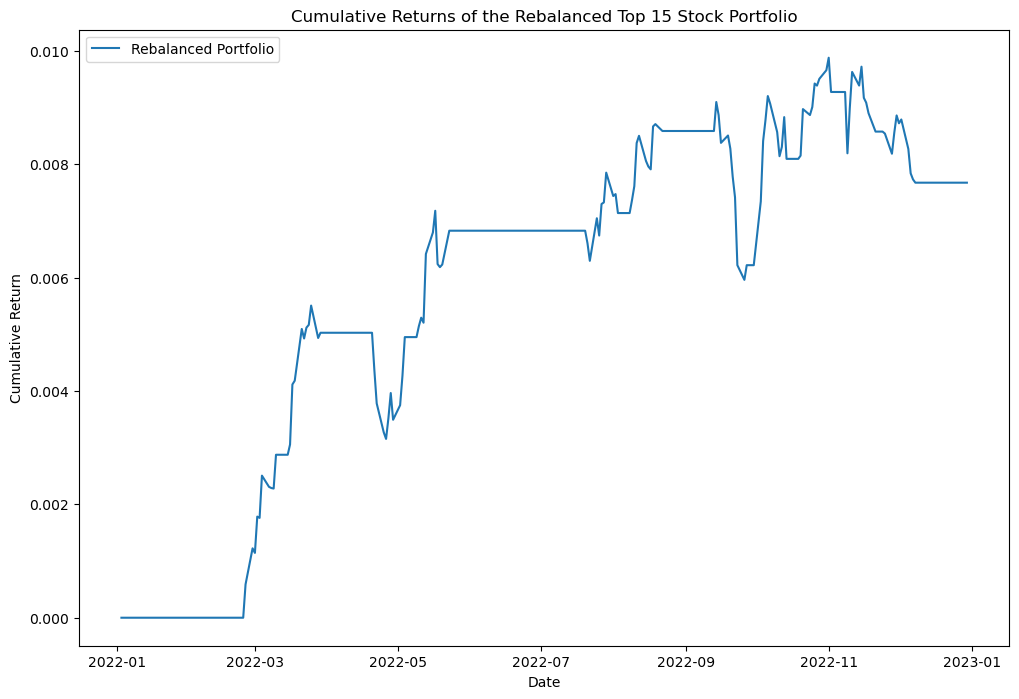

In [83]:
# Plot the cumulative returns for the rebalanced portfolio
plt.figure(figsize=(12, 8))
plt.plot(rebalanced_cumulative_returns.index, rebalanced_cumulative_returns, label='Rebalanced Portfolio')
plt.legend()
plt.title('Cumulative Returns of the Rebalanced Top 15 Stock Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

In [89]:
# Initialize portfolio on the first rebalance date with out using .mean() 这我就把上边copy下来然后把选股的逻辑改了一下，没啥大变化
for date in rebalance_dates:
    try:
        if current_portfolio.empty:
            # Select top 15 stocks based on the latest combined score
            latest_scores = factor_data_V.loc[date]
            top_stocks = latest_scores.nlargest(7, 'combined_score')
            top_stocks_index = top_stocks['ticker']
            top_stocks_scores = top_stocks['combined_score']

            # Assign weights based on the combined scores
            weights = top_stocks_scores / top_stocks_scores.sum()

            for stock, weight in zip(top_stocks_index, weights):
                shares_to_buy = (portfolio_value * weight) / all_data[stock]['Adj Close'].loc[date]
                cash -= shares_to_buy * all_data[stock]['Adj Close'].loc[date]
                current_portfolio = current_portfolio.append({'ticker': stock, 'shares': shares_to_buy, 'weight': weight}, ignore_index=True)

        current_returns = rebalanced_portfolio_returns.loc[:date].dropna()
        if not current_returns.empty:
            cumulative_return = (1 + current_returns).prod() - 1
            if cumulative_return >= 0.05:
                # Sell the best 2 stocks
                best_stocks = current_portfolio.sort_values(by='weight', ascending=False).head(2)['ticker']
                for stock in best_stocks:
                    cash += all_data[stock]['Adj Close'].loc[date] * current_portfolio.loc[current_portfolio['ticker'] == stock, 'shares'].values[0]
                    current_portfolio = current_portfolio[current_portfolio['ticker'] != stock]
                
                # Buy other stocks with the highest score
                for stock, weight in zip(top_stocks_index, weights):
                    if stock not in current_portfolio['ticker'].values:
                        shares_to_buy = (cash * weight) / all_data[stock]['Adj Close'].loc[date]
                        cash -= shares_to_buy * all_data[stock]['Adj Close'].loc[date]
                        current_portfolio = current_portfolio.append({'ticker': stock, 'shares': shares_to_buy, 'weight': weight}, ignore_index=True)
            
            elif cumulative_return <= -0.03:
                # Sell the worst stock
                worst_stock = current_portfolio.sort_values(by='weight').head(1)['ticker'].values[0]
                cash += all_data[worst_stock]['Adj Close'].loc[date] * current_portfolio.loc[current_portfolio['ticker'] == worst_stock, 'shares'].values[0]
                current_portfolio = current_portfolio[current_portfolio['ticker'] != worst_stock]
                
                # Buy other stocks with the highest score
                for stock, weight in zip(top_stocks_index, weights):
                    if stock not in current_portfolio['ticker'].values:
                        shares_to_buy = (cash * weight) / all_data[stock]['Adj Close'].loc[date]
                        cash -= shares_to_buy * all_data[stock]['Adj Close'].loc[date]
                        current_portfolio = current_portfolio.append({'ticker': stock, 'shares': shares_to_buy, 'weight': weight}, ignore_index=True)
        
        # Calculate portfolio returns
        portfolio_returns = []
        for stock in current_portfolio['ticker']:
            stock_return = all_data[stock]['daily_return'].loc[date:date + pd.DateOffset(days=rebalance_period)]
            if not stock_return.empty:
                portfolio_returns.append(stock_return * current_portfolio.loc[current_portfolio['ticker'] == stock, 'shares'].values[0] / portfolio_value)
        
        # Check if the lengths match before assignment
        if len(portfolio_returns) > 0 and len(np.sum(portfolio_returns, axis=0)) == len(rebalanced_portfolio_returns.loc[date:date + pd.DateOffset(days=rebalance_period)]):
            rebalanced_portfolio_returns.loc[date:date + pd.DateOffset(days=rebalance_period)] = np.sum(portfolio_returns, axis=0)
        
        # Update portfolio value
        portfolio_value = calculate_portfolio_value(current_portfolio, all_data, date) + cash
        
        # Print the current state of the portfolio
        print_portfolio_state(date, portfolio_value, cash, current_portfolio)
    except Exception as e:
        print(f"Failed to process rebalance for {date}: {e}")

Date: 2022-01-03 00:00:00
Portfolio Value: 845135.5328136645
Cash: -5.820766091346741e-11
Current Portfolio:
   ticker       shares    weight
0     LVS  2253.065761  0.101461
1     HAL  3130.135257  0.095363
2     XOM  1260.028068  0.092443
3     OXY  2346.643071  0.089837
4    FICO   170.951380  0.087609
5     GLW  2174.614132  0.085624
6     UPS   409.257112  0.083915
7     APA  2538.887484  0.079168
8     PKG   524.536044  0.072548
9     MOS  1680.552905  0.071826
10    MRO  3506.668907  0.071301
11    AXP   366.503225  0.068905


Date: 2022-01-20 00:00:00
Portfolio Value: 890313.3065962137
Cash: -5.820766091346741e-11
Current Portfolio:
   ticker       shares    weight
0     LVS  2253.065761  0.101461
1     HAL  3130.135257  0.095363
2     XOM  1260.028068  0.092443
3     OXY  2346.643071  0.089837
4    FICO   170.951380  0.087609
5     GLW  2174.614132  0.085624
6     UPS   409.257112  0.083915
7     APA  2538.887484  0.079168
8     PKG   524.536044  0.072548
9     MOS  1680.55290

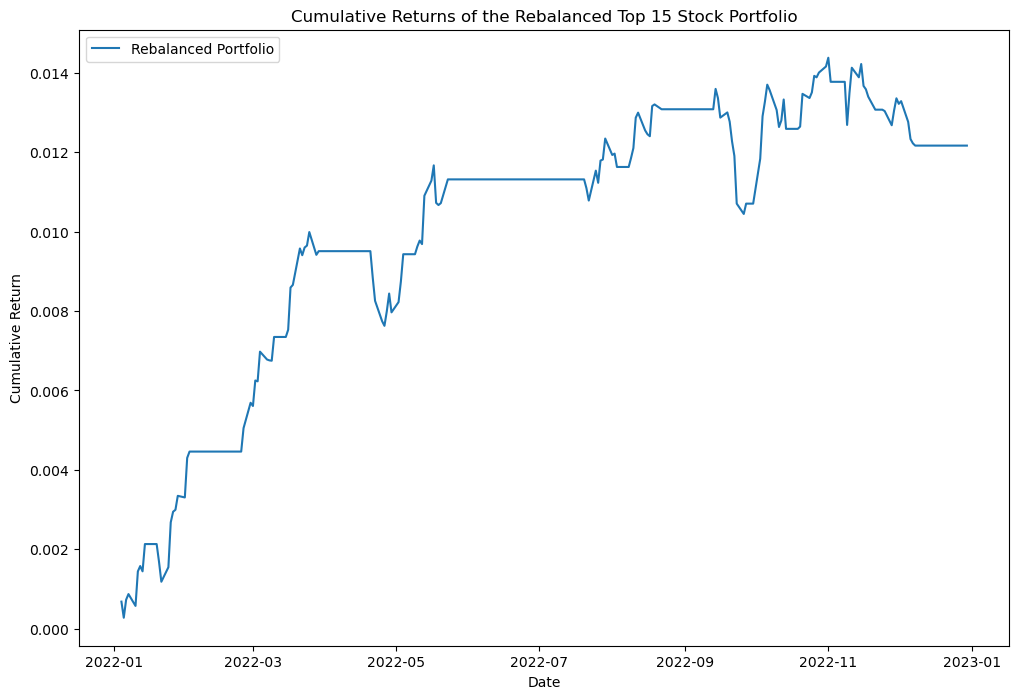

In [90]:
# Calculate the cumulative returns for the rebalanced portfolio
rebalanced_cumulative_returns = (1 + rebalanced_portfolio_returns).cumprod() - 1

# Plot the cumulative returns for the rebalanced portfolio
plt.figure(figsize=(12, 8))
plt.plot(rebalanced_cumulative_returns.index, rebalanced_cumulative_returns, label='Rebalanced Portfolio')
plt.legend()
plt.title('Cumulative Returns of the Rebalanced Top 15 Stock Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()